In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from google.colab import files

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move the uploaded file to the appropriate directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [3]:
!kaggle datasets download -d datamunge/sign-language-mnist

Dataset URL: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
License(s): CC0-1.0
 94% 59.0M/62.6M [00:00<00:00, 174MB/s]
100% 62.6M/62.6M [00:00<00:00, 156MB/s]


In [4]:
!unzip /content/sign-language-mnist.zip

Archive:  /content/sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


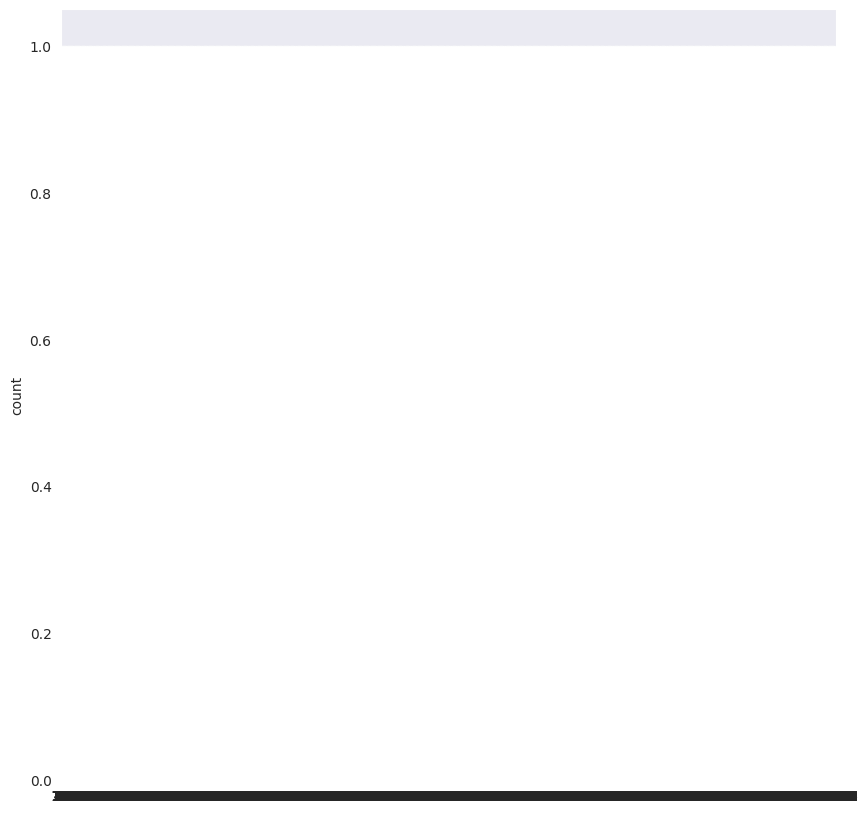

In [5]:


# Load the ASL dataset
train_df = pd.read_csv("/content/sign_mnist_train.csv")
test_df = pd.read_csv("/content/sign_mnist_test.csv")

# Data visualization and preprocessing
plt.figure(figsize=(10, 10))  # Label count
sns.set_style("darkgrid")
sns.countplot(train_df['label'])
plt.show()

In [6]:



# Separate features and labels
y_train = train_df['label']
y_test = test_df['label']
x_train = train_df.drop(columns=['label']).values
x_test = test_df.drop(columns=['label']).values

# Binarize labels
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape the data to 3D
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

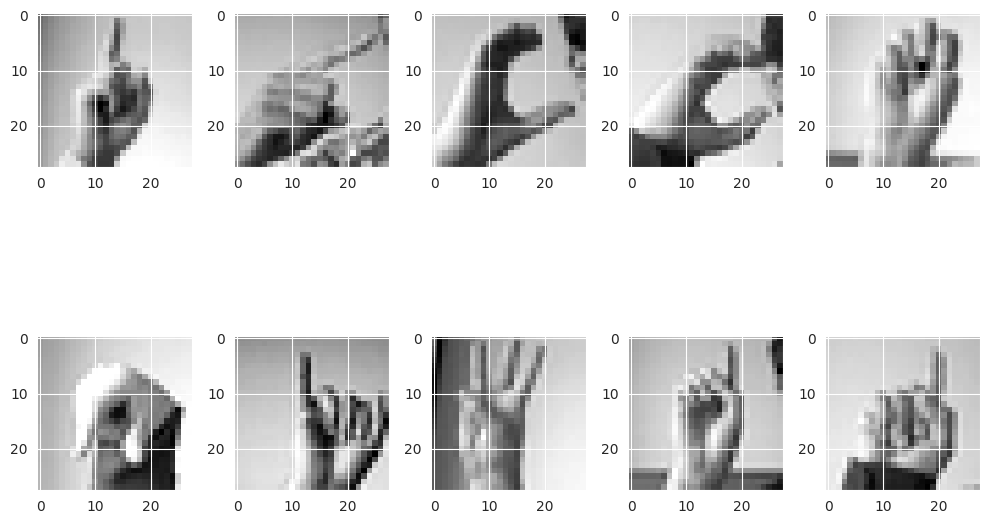

In [7]:


# Preview of the first 10 images
f, ax = plt.subplots(2, 5)
f.set_size_inches(10, 10)
k = 0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(x_train[k].reshape(28, 28), cmap="gray")
        k += 1
    plt.tight_layout()
plt.show()


In [8]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)
datagen.fit(x_train)

In [9]:

# Define the CNN model
def build_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(75, (3, 3), strides=1, padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Conv2D(50, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Conv2D(25, (3, 3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units=num_classes, activation='softmax'))
    return model

# Build and compile the model
input_shape = (28, 28, 1)
num_classes = 24  # Excluding J (9) and Z (25)
model = build_cnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 75)        300       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 75)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 50)        2

In [10]:
# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=20,
    validation_data=(x_test, y_test)

)

Epoch 1/20
215/215 [==============================] - 15s 39ms/step - loss: 1.0569 - accuracy: 0.6673 - val_loss: 5.4006 - val_accuracy: 0.0608
Epoch 2/20
215/215 [==============================] - 8s 37ms/step - loss: 0.2069 - accuracy: 0.9329 - val_loss: 1.1195 - val_accuracy: 0.6456
Epoch 3/20
215/215 [==============================] - 8s 36ms/step - loss: 0.1022 - accuracy: 0.9663 - val_loss: 0.1567 - val_accuracy: 0.9492
Epoch 4/20
215/215 [==============================] - 8s 36ms/step - loss: 0.0635 - accuracy: 0.9792 - val_loss: 0.0740 - val_accuracy: 0.9826
Epoch 5/20
215/215 [==============================] - 8s 37ms/step - loss: 0.0471 - accuracy: 0.9843 - val_loss: 0.1194 - val_accuracy: 0.9582
Epoch 6/20
215/215 [==============================] - 8s 36ms/step - loss: 0.0347 - accuracy: 0.9887 - val_loss: 0.0150 - val_accuracy: 0.9960
Epoch 7/20
215/215 [==============================] - 8s 37ms/step - loss: 0.0287 - accuracy: 0.9914 - val_loss: 0.0176 - val_accuracy: 0.996

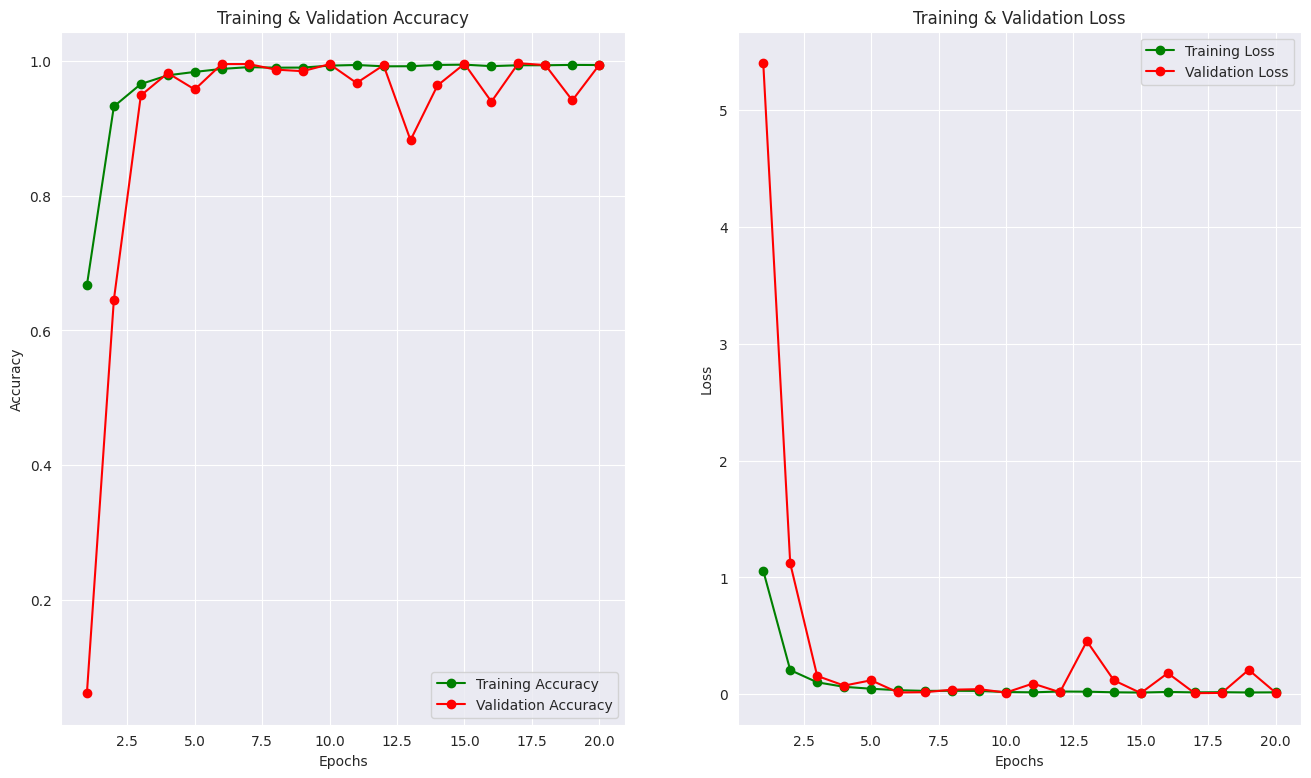

In [11]:


# Plot training history
plt.figure(figsize=(16, 9))
epochs = range(1, 21)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'go-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()



225/225 [==============================] - 1s 2ms/step - loss: 0.0135 - accuracy: 0.9948
Accuracy of the model is - 99.48%
225/225 [==============================] - 1s 2ms/step


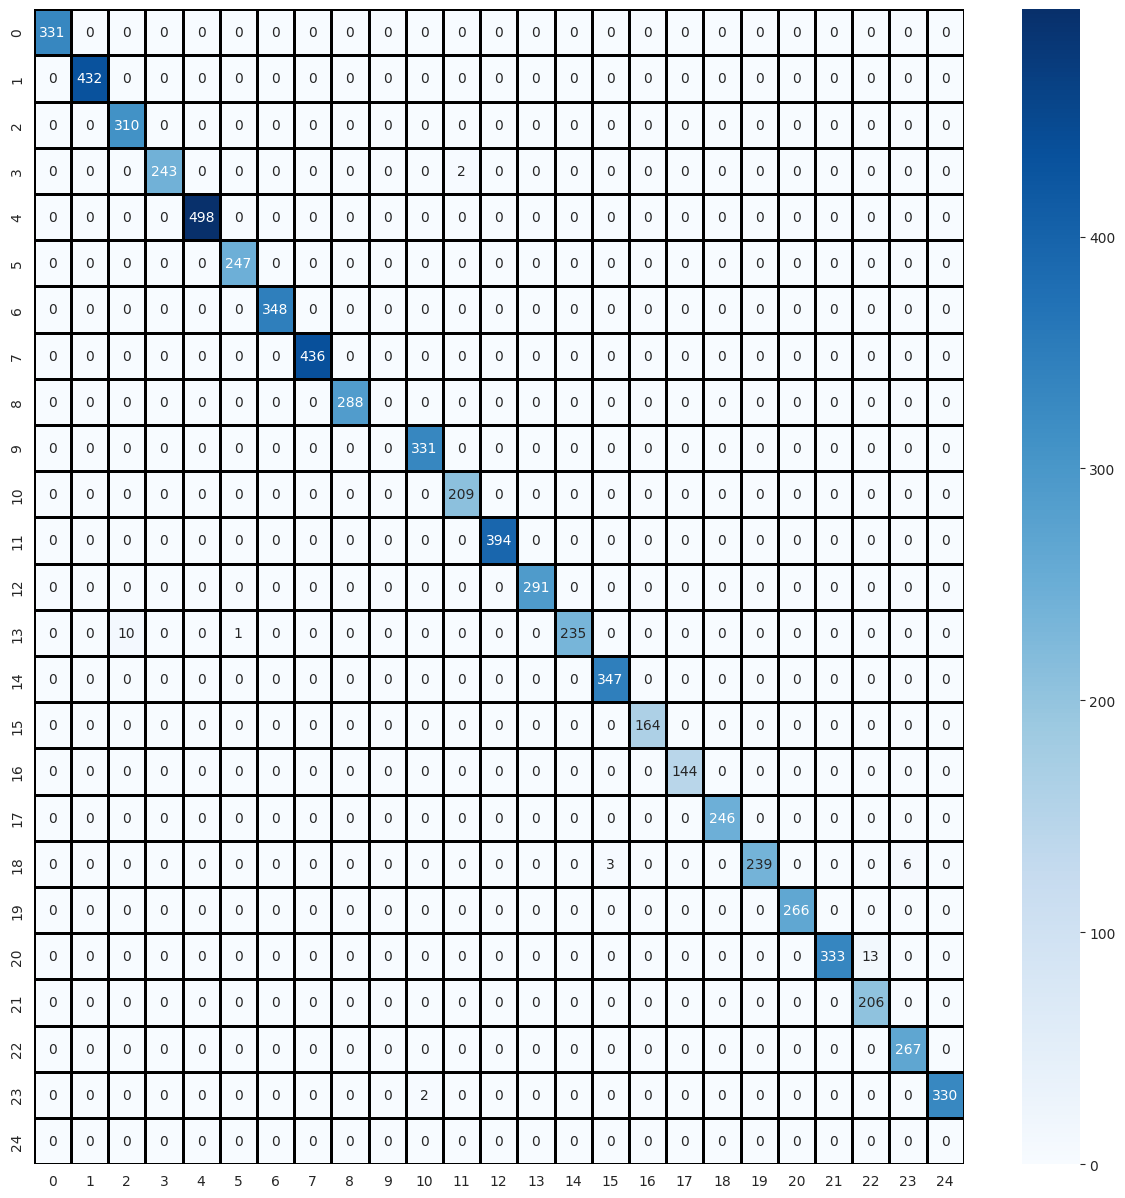

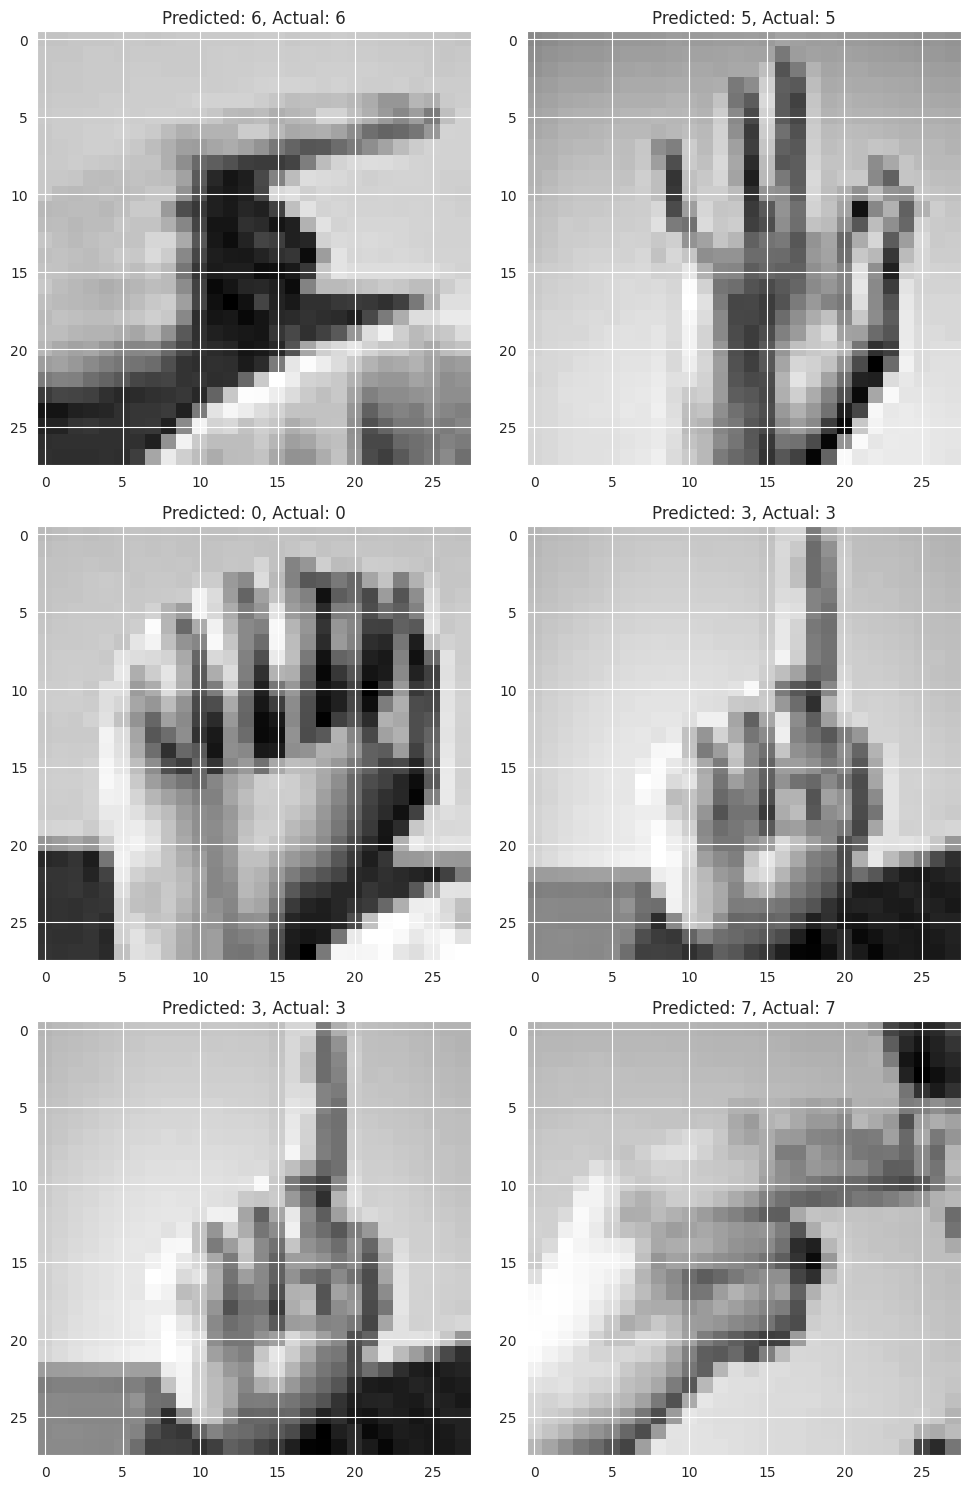

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Accuracy of the model is - {test_accuracy * 100:.2f}%')

# Predictions
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

# Adjust predictions for missing classes (J and Z)
for i in range(len(predictions)):
    if predictions[i] >= 9:
        predictions[i] += 1



# Confusion matrix
cm = confusion_matrix(y_true, predictions)

plt.figure(figsize=(15, 15))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='')
plt.show()

# Display some correctly predicted classes
correct = np.nonzero(predictions == y_true)[0]
f, ax = plt.subplots(3, 2)
f.set_size_inches(10, 15)
for i, c in enumerate(correct[:6]):
    ax[i // 2, i % 2].imshow(x_test[c].reshape(28, 28), cmap="gray", interpolation='none')
    ax[i // 2, i % 2].set_title(f"Predicted: {predictions[c]}, Actual: {y_true[c]}")
plt.tight_layout()
plt.show()
